<h1><center> Action Recognition with CAM visualization </center> </h1>

<br>Author: Wendell Hom
<br>Dataset: Stanford-40 action
<br>Architecture: MobileNet-v2
<br>Input Image Size: 500x500x3
<br>Initial Learning Rate: 10^0-4, decrease by a factor of 10 if no improvement to validation loss


This notebook implements action recognition CNN using MobileNet-v2, and includes a Global Average Pooling layer followed by a 40-way softmax which uses categorical crossentropy.
The GAP layer makes it simple to visualize the class activation map in order to understand which parts of the image was significant in leading the model to the given prediction.

A few images downloaded from the web was also used to do inference in the wild at the bottom of this notebook.


In [1]:
import tensorflow as tf


# Check tensorflow version
print("Using Tensorflow %s\n" % (tf.__version__))

# Check to see if graphics card is doing OK memory-wise
!nvidia-smi

Using Tensorflow 2.0.0

Sat Mar 14 19:00:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.87.01    Driver Version: 418.87.01    CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                    

In [2]:
%load_ext tensorboard

In [3]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

from sklearn import metrics
import math
import numpy as np
from tensorflow.keras.models       import Model


## Create or Load MobileNet v2 Model

In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

restore_model = False
pixels = 224

if (restore_model):    
    model = load_model('models/class_only/checkpoints/epoch_31-0.65.h5')
else:

    # MobileNet doesn't allow 500x500.  Max size is 224x224.
    conv_base = MobileNetV2(weights='imagenet', include_top=False, input_shape=(pixels, pixels,3))

    conv_base.trainable = False

    model = models.Sequential()
    model.add(conv_base)
    model.add(layers.Conv2D(1024, (3, 3), padding="same", strides=(1, 1), activation="relu", name="ClassConv"))
    model.add(layers.GlobalAveragePooling2D(name="GAP"))
    model.add(layers.Dense(40, activation="softmax", name="class"))    

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
ClassConv (Conv2D)           (None, 7, 7, 1024)        11797504  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
class (Dense)                (None, 40)                41000     
Total params: 14,096,488
Trainable params: 11,838,504
Non-trainable params: 2,257,984
_________________________________________________________________


In [5]:
all_amp_layer_weights = model.layers[-1].get_weights()[0]

In [6]:
all_amp_layer_weights.shape

(1024, 40)

In [7]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])
cam_shape

(7, 7, 1024)

## Create train and test generators

In [8]:
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
BATCH_SIZE = 128


train_generator = train_datagen.flow_from_directory("Stanford40/train", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical')
valid_generator = test_datagen.flow_from_directory("Stanford40/test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)

y_true = valid_generator.classes

train_m = len(train_generator.classes)
valid_m = len(valid_generator.classes)

mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

train_steps = math.ceil(train_m/BATCH_SIZE)
valid_steps = math.ceil(valid_m/BATCH_SIZE)



Found 6693 images belonging to 40 classes.
Found 2839 images belonging to 40 classes.


In [10]:
import os

filepath = "models/class_only/checkpoints/epoch_{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='min')

class LossHistory(tf.keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.losses = []
        self.acc = []
        self.epoch_loss = []
        self.epoch_acc = []
        self.epoch_val_loss = []
        self.epoch_val_acc = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('acc'))

    def on_epoch_end(self, batch, logs={}):
        try:
            self.epoch_loss.append(logs.get('loss'))
            self.epoch_acc.append(logs.get('acc'))
            self.epoch_val_loss.append(logs.get('val_loss'))
            self.epoch_val_acc.append(logs.get('val_acc'))
        except:
            print("Failed log data on epoch end")
        
    
class EarlyStop(tf.keras.callbacks.Callback):
    """Callback that terminates training when flag=1 is encountered.
    """
    def on_batch_end(self, batch, logs=None):
        if os.path.exists("./keras.end_batch"):    
            self.model.stop_training = True
            
    def on_epoch_end(self, batch, logs=None):
        if os.path.exists("./keras.end_epoch"):
            self.model.stop_training = True
        

from tensorflow.keras.callbacks import CSVLogger

csv_logger = CSVLogger("training_log.csv", separator=',', append=False)
history_logger = LossHistory()
early_stop = EarlyStop()

callbacks = [checkpoint, early_stop, history_logger, csv_logger]


In [11]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(lr=1e-4), metrics = ['acc'])


In [12]:
prev_epochs = 0
epochs = 20

In [13]:
history = model.fit_generator(train_generator, steps_per_epoch=train_steps, initial_epoch=prev_epochs, epochs=epochs, validation_data=valid_generator, validation_steps=valid_steps, callbacks=callbacks)

Epoch 1/20
52/53 [============================>.] - ETA: 1s - loss: 2.0261 - acc: 0.4698
Epoch 00001: val_loss improved from inf to 1.37739, saving model to models/class_only/checkpoints/epoch_01-1.38.h5
53/53 [==============================] - 114s 2s/step - loss: 2.0149 - acc: 0.4718 - val_loss: 1.3774 - val_acc: 0.6073
Epoch 2/20
52/53 [============================>.] - ETA: 1s - loss: 1.0897 - acc: 0.6832
Epoch 00002: val_loss did not improve from 1.37739
53/53 [==============================] - 102s 2s/step - loss: 1.0881 - acc: 0.6836 - val_loss: 1.4759 - val_acc: 0.6037
Epoch 3/20
52/53 [============================>.] - ETA: 1s - loss: 0.9031 - acc: 0.7333
Epoch 00003: val_loss improved from 1.37739 to 1.37708, saving model to models/class_only/checkpoints/epoch_03-1.38.h5
53/53 [==============================] - 103s 2s/step - loss: 0.9018 - acc: 0.7336 - val_loss: 1.3771 - val_acc: 0.6273
Epoch 4/20
52/53 [============================>.] - ETA: 1s - loss: 0.7752 - acc: 0.7671

## Saving the Model

In [14]:
model.save("models/class_only/MobileNet-v2-20_epochs.h5")

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
ClassConv (Conv2D)           (None, 7, 7, 1024)        11797504  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
class (Dense)                (None, 40)                41000     
Total params: 14,096,488
Trainable params: 11,838,504
Non-trainable params: 2,257,984
_________________________________________________________________


## Plotting Loss and Acc

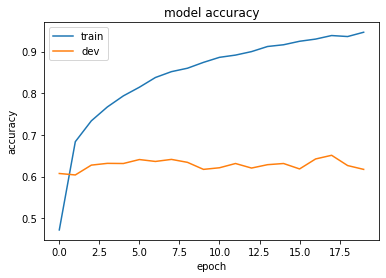

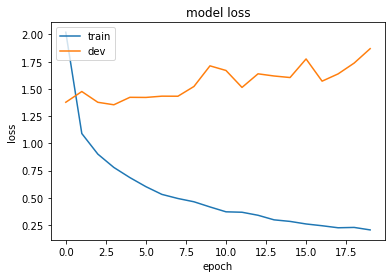

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'dev'], loc='upper left')
plt.show()

## Confusion Matrix

In [25]:
cam_shape = tuple(model.get_layer("ClassConv").output.get_shape().as_list()[1:])


# custom generator
def multiple_outputs(generator, image_dir, batch_size, image_size):
    gen = generator.flow_from_directory(
        image_dir,
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical', shuffle=False)
    
    while True:
        gnext = gen.next()
        # return image batch and 3 sets of lables
        #yield gnext[0], [np.zeros((gnext[1].shape[0], 14, 14, 1024)), gnext[1]]
        yield gnext[0], [np.zeros((gnext[1].shape[0], *cam_shape)), gnext[1]]

In [26]:
BATCH_SIZE = 12

pixels = 224
train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=10, zoom_range= [0.9,1.1])
test_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = multiple_outputs(test_datagen, 
                                   image_dir="Stanford40/test", 
                                   batch_size=BATCH_SIZE, 
                                   image_size=pixels)

valid_temp = test_datagen.flow_from_directory("Stanford40/test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)
y_true = valid_temp.classes

valid_m = len(valid_temp.classes)

mapping = dict()
for activity, idx in valid_temp.class_indices.items():
    mapping[idx] = activity


valid_steps = math.ceil(valid_m/BATCH_SIZE)


Found 2839 images belonging to 40 classes.


In [27]:
BATCH_SIZE = 12

valid_generator = test_datagen.flow_from_directory("Stanford40/test", batch_size=BATCH_SIZE, target_size=(pixels,pixels), class_mode = 'categorical', shuffle=False)

y_true = valid_generator.classes

valid_m = len(valid_generator.classes)

mapping = dict()
for activity, idx in train_generator.class_indices.items():
    mapping[idx] = activity

valid_steps = math.ceil(valid_m/BATCH_SIZE)


Found 2839 images belonging to 40 classes.


In [28]:
predictions = model.predict_generator(valid_generator, valid_steps)

In [29]:
predictions = predictions.argmax(axis=1)

In [30]:
len(predictions)

2839

In [31]:
(y_true == predictions).mean()

0.6171187037689327

In [32]:
mapping[5]

'cooking'

In [33]:
matrix = metrics.confusion_matrix(y_true, predictions)

## Plot confusion matrix

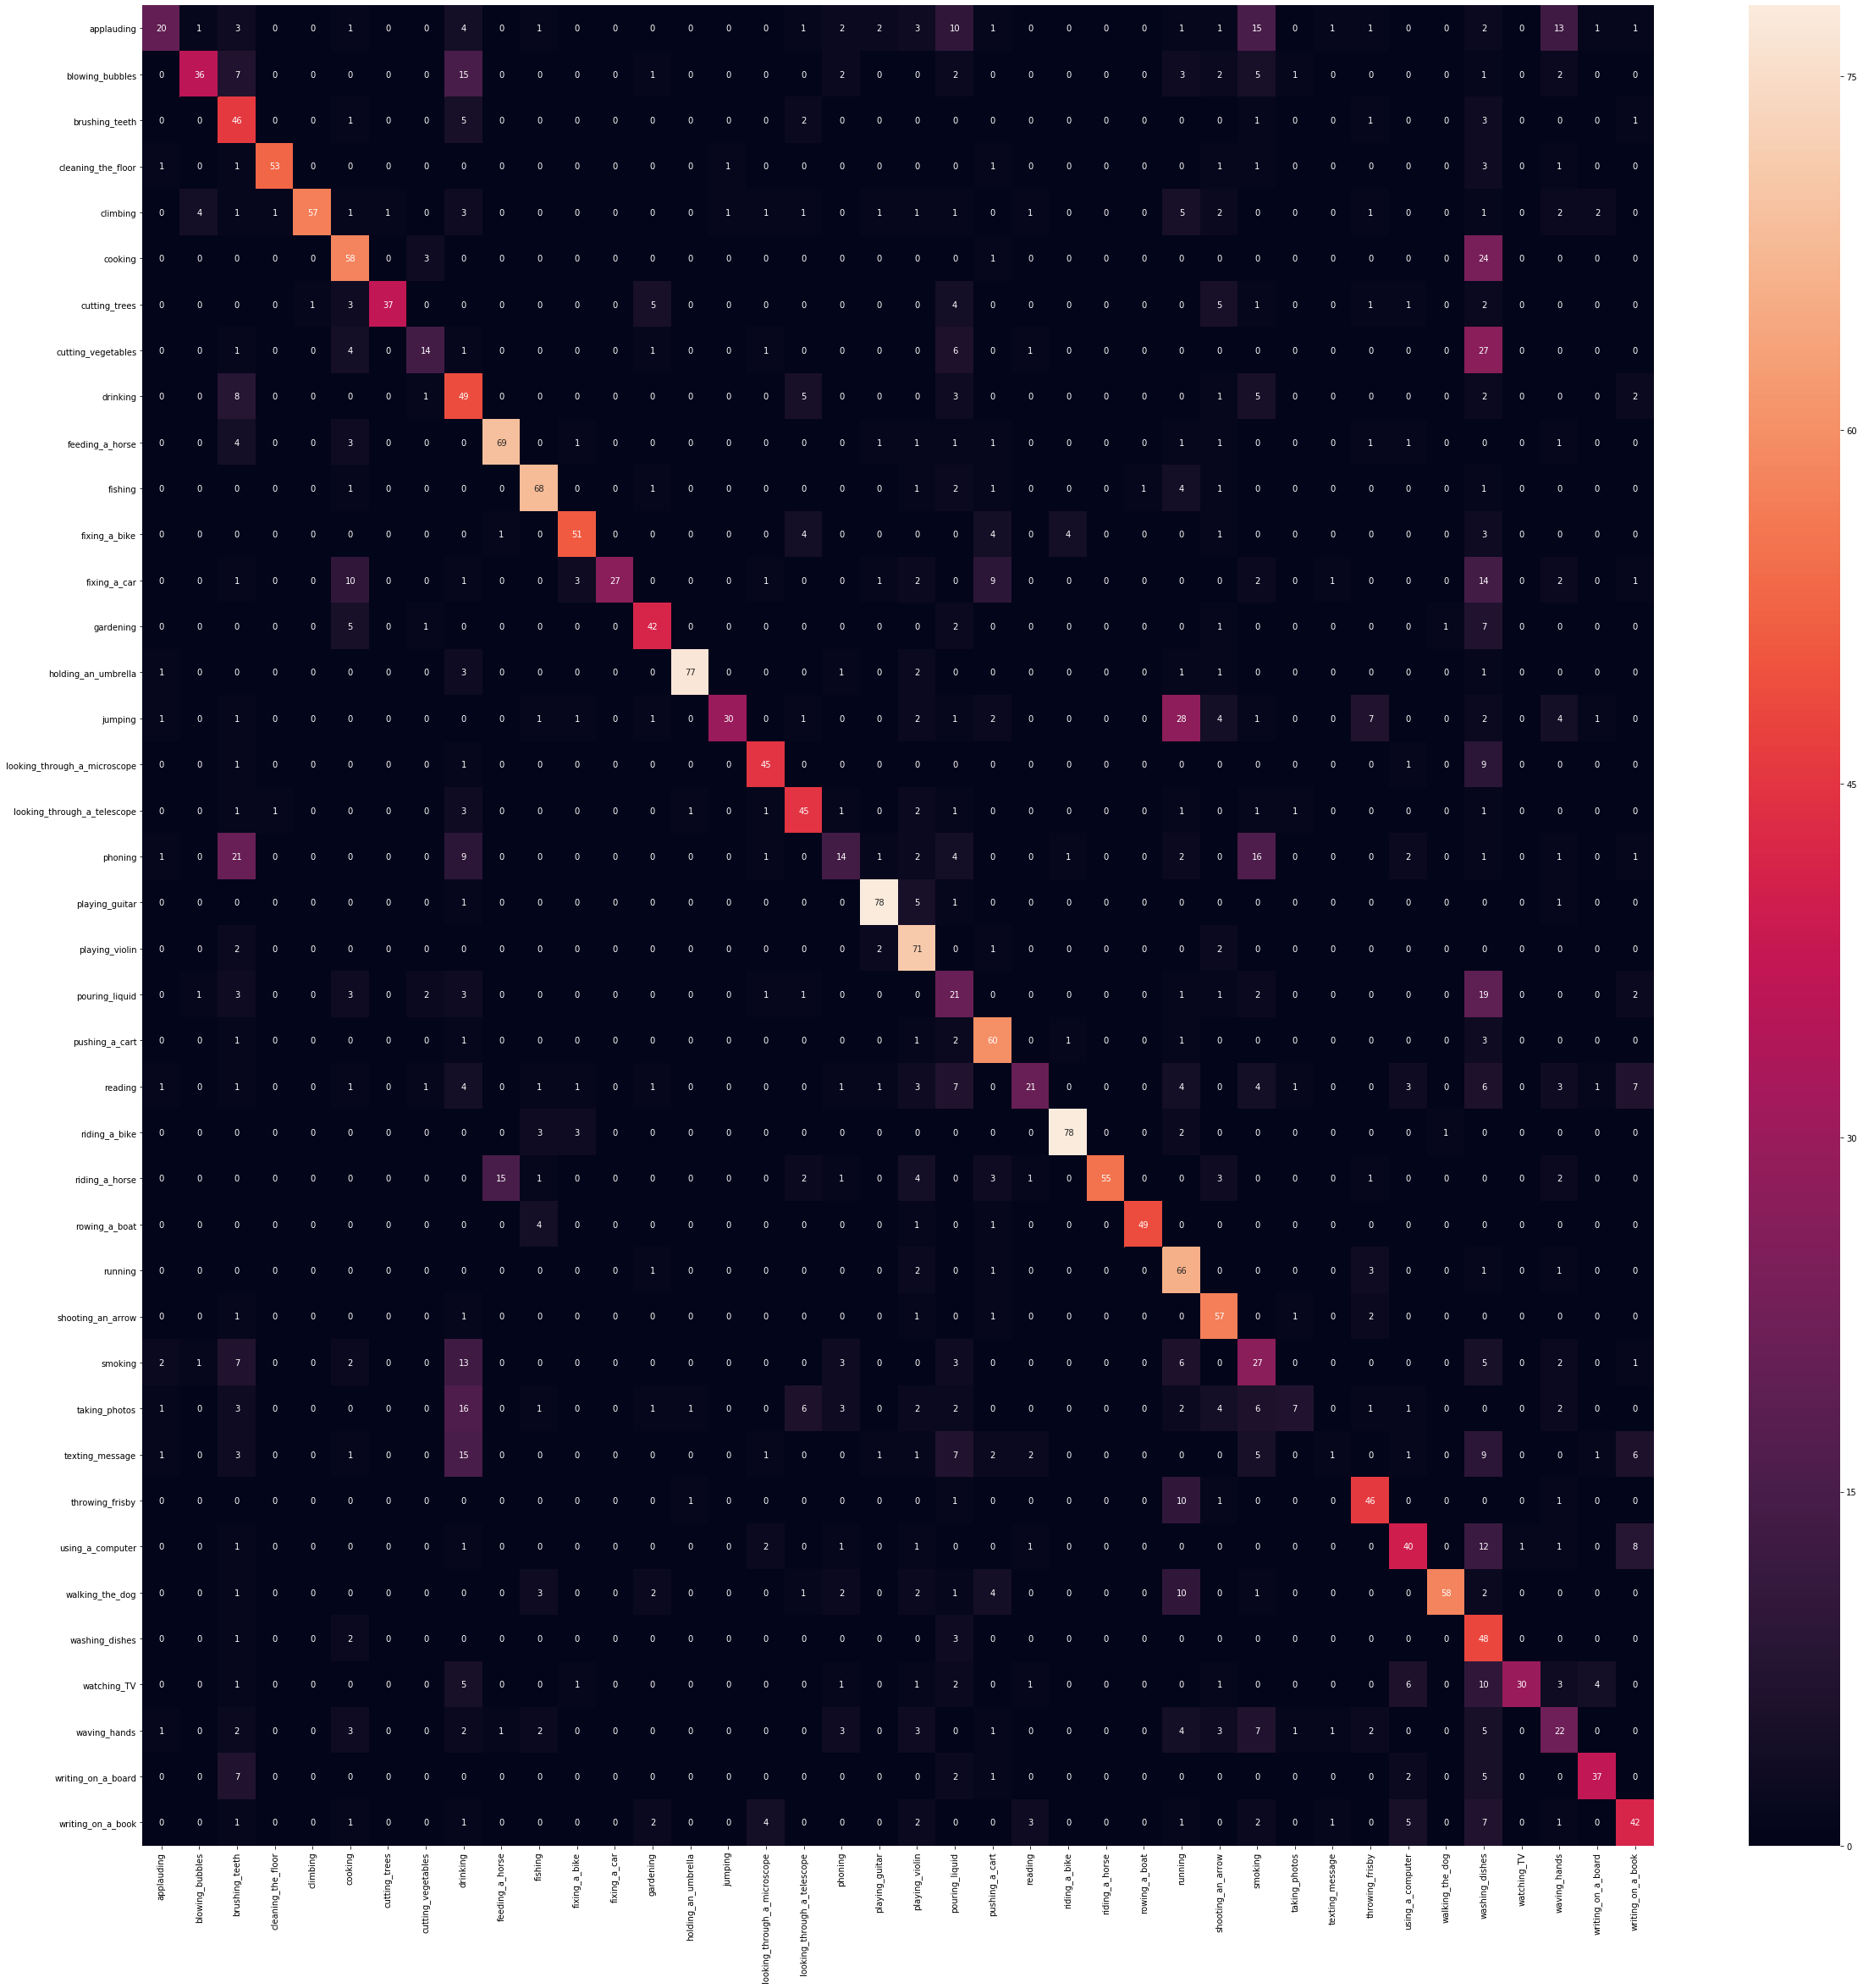

In [34]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(matrix, index = [mapping[i] for i in range(40)], columns = [mapping[i] for i in range(40)])
plt.figure(figsize = (40, 40))
sn.heatmap(df_cm, annot=True)

In [35]:
import pickle
with open('ResNet-50-40_epochs-history.txt', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)


## Predicting from own image

In [36]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def predict_image(file, model, mapping):
    
    # load an image from file
    image = load_img(file, target_size=(224, 224))
    image = img_to_array(image)
    image = image.reshape((1,image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    
    cam, yhat = model.predict(image)
    print(cam.shape)
    print(yhat.shape)
    category = np.argmax(yhat)
    return mapping[category]


In [37]:
all_amp_layer_weights=model.layers[-1].get_weights()[0]

In [38]:
all_amp_layer_weights.shape

(1024, 40)

In [39]:
final_model = Model(inputs = model.input, 
                  outputs = (model.get_layer("ClassConv").output, model.get_layer("class").output))
            
final_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224_input ( [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
ClassConv (Conv2D)           (None, 7, 7, 1024)        11797504  
_________________________________________________________________
GAP (GlobalAveragePooling2D) (None, 1024)              0         
_________________________________________________________________
class (Dense)                (None, 40)                41000     
Total params: 14,096,488
Trainable params: 11,838,504
Non-trainable params: 2,257,984
_________________________________________________________________


In [40]:
pixels = final_model.input.get_shape().as_list()[1]
pixels

224

In [41]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input

def predict(img_path, model, all_amp_layer_weights):
    
    # Load and preprocess image
    img = image.load_img(img_path, target_size=(pixels,pixels))
    
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    processed_input = preprocess_input(x)
    
    # Run model's prediction to output from last Conv Layer + category prediction
    last_conv_output, pred_vec = final_model.predict(processed_input)
    # Only 1 training example, so remove batch dimension
    last_conv_output = np.squeeze(last_conv_output)

    # Get category with highest probability
    pred = np.argmax(pred_vec)
    
    scale = pixels / last_conv_output.shape[0]
    filters = last_conv_output.shape[2]
    
    # Rescale to input image sizederstanding was it's reserved for the fi
    mat_for_mult = scipy.ndimage.zoom(last_conv_output, (scale,scale,1), order=1)
    
    # Get the weights associated with the predicted class
    amp_layer_weights = all_amp_layer_weights[:, pred]
    
    # Weighted sum of the activation maps for the predicted class.
    # Then resize back to original image size.
    final_output = np.dot(mat_for_mult.reshape((pixels*pixels, filters)), amp_layer_weights).reshape(pixels,pixels)
    
    return final_output, mapping[pred]
    

In [ ]:
import matplotlib.pyplot as plt
import scipy
import glob

from tensorflow.keras.preprocessing import image

# Images downloaded from internet search engine to try out activity classification
# Images are under images/ directory 
image_dir = "images/"
pattern  = image_dir + "*"
test_images = sorted(glob.glob(pattern))

# Details for the grid size
columns = 4
rows = math.ceil(len(test_images) / columns)
fig = plt.figure(figsize=(80, 20 * rows))

for i, image_name in enumerate(test_images):

    # Progress report
    print(".", end = '')
    image_path = image_dir + image_name
    
    ax = fig.add_subplot(rows, columns, i+1)

    # Load and display original image
    img = tf.keras.preprocessing.image.load_img(image_name, target_size=(pixels,pixels))
    plt.imshow(img)
    
    # Run forward pass to get the Class Activity Map and the predicted class
    cam, pred = predict(image_name, model, all_amp_layer_weights)
    
    # Display class activation map
    plt.imshow(cam, cmap='jet', alpha=0.5)
    # Set title to that of predicted class
    ax.set_title(pred, fontsize =60)
    
    
plt.show()

..............

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))